<a href="https://colab.research.google.com/github/JesiJackson/Random-Forest/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

In [2]:
# Import the data set
df = pd.read_excel('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UEym8G6lwphKjuhkLgkXAg/default%20of%20credit%20card%20clients.xls', header=1)

In [3]:
# Explore the data set
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Some columns that could be useful are:
- `LIMIT_BAL:` credit limit.
- `PAY_0, ..., PAY_6:` prior payment status.
- `BILL_AMT, PAY_AMT:` bill and payment amounts.
- `default payment next month:` target variable that indicates default next month.

In [4]:
# Remove the ID columns as it is not informative
df.drop(columns = ['ID'], inplace = True)
# Rename columns
df.rename(columns = {'default payment next month':'DEFAULT'}, inplace = True)
df.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


**ANALYZE DATA**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [6]:
print(f"SEX values: {df['SEX'].value_counts()}")
print(f"MARRIAGE values: {df['MARRIAGE'].value_counts()}")
print(f"EDUCATION values: {df['EDUCATION'].value_counts()}")

SEX values: SEX
2    18112
1    11888
Name: count, dtype: int64
MARRIAGE values: MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64
EDUCATION values: EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64


The output indicates that some of the data does not align with the data definitions, specifically the EDUCATION and MARRIAGE columns.

**EDUCATION** includes three types of invalid values, which are 0, 5, and 6.   

**MARRIAGE** includes 0 as an invalid value.

Assume that a 0 encoding is supposed to represent missing data and that a value of 5 or 6 within EDUCATION is representative of other unspecified education levels (for example, Ph.D. or a master's degree), which is not represented within the data definition.

In [7]:
invalid_zero = len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])
print(f"Number of 0 invalid data in EDUCATION or MARRIAGE: {invalid_zero}")

Number of 0 invalid data in EDUCATION or MARRIAGE: 68


In [8]:
# DataFrame with missing values for Education and Marriage removed
df1 = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
df1.shape

(29932, 24)

<ipython-input-9-f5497366d91d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.countplot(x = df1['DEFAULT'], palette = 'Set2')


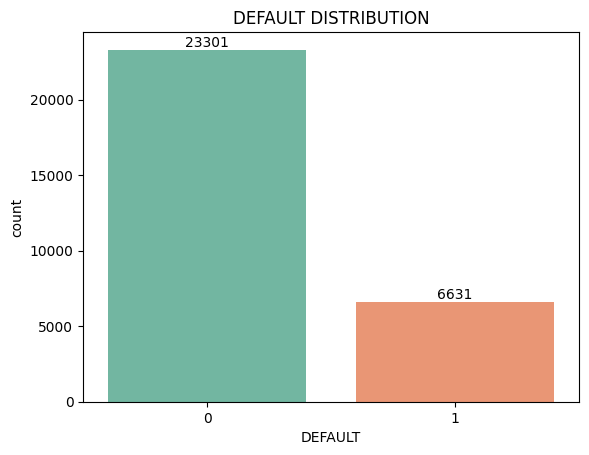

In [9]:
# Explore default distribution
fig = sns.countplot(x = df1['DEFAULT'], palette = 'Set2')
# Add the value of each bar at the top
for container in fig.containers:
  fig.bar_label(container)

plt.title('DEFAULT DISTRIBUTION')
plt.show()

The chart shows counts of people who have defaulted (1) and haven't defaulted (0).
Unsurprisingly, most people have not defaulted on their loans.

To address this class imbalance, we must down sample the data.

**DOWNSAMPLE THE DATA SET**

In [10]:
# Split the data
df_default = df1.loc[df1['DEFAULT'] == 1]
df_no_default = df1.loc[df1['DEFAULT'] == 0]
# Downsample the data
df_default_downsample = resample(df_default, replace = False, n_samples = 2000, random_state = 0)
df_no_default_downsample = resample(df_no_default, replace = False, n_samples = 2000, random_state = 0)
# Merge samples
df_downsample = pd.concat([df_default_downsample, df_no_default_downsample])
df_downsample.shape

(4000, 24)

**HOT ENCODE THE INDEPENDENT VARIABLES**

Avoid using variables like SEX, AGE, and MARRIAGE as independent variables because they are protected attributes and could lead to biased or discriminatory outcomes.

EDUCATION is somewhat more ambiguous. Because it is not critical for the purposes of this project, this is dropped as well.

In [11]:
# Isolate independent variables
X = df_downsample.drop(columns = ['DEFAULT', 'SEX', 'AGE', 'MARRIAGE', 'EDUCATION']).copy()
# Encode variables
X_encoded = pd.get_dummies(data = X, columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
X_encoded.head(3)

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
6051,30000,2450,4765,3767,4151,3940,3697,4777,3770,4151,...,False,True,False,False,False,False,False,False,False,False
23526,100000,103307,97590,99560,95952,98744,97896,0,4700,4400,...,False,False,False,True,False,False,False,False,False,False
17364,50000,49819,49390,50612,29975,30559,29433,2227,2449,1778,...,False,False,False,True,False,False,False,False,False,False


**MODELING**

Accuracy: 70.42%
Percentage of correctly predicted Did not Default:78.96%
Percentage of correctly predicted Default:61.90%


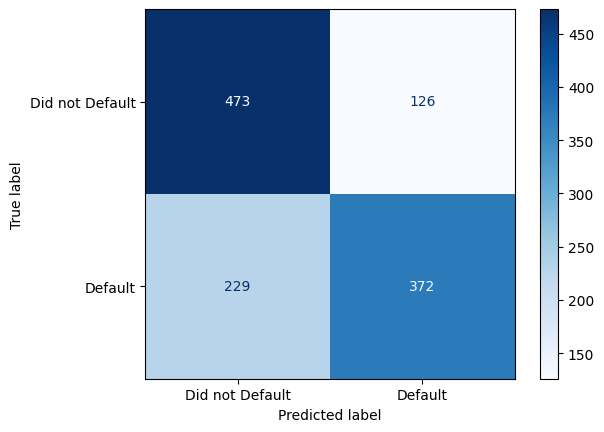

In [12]:
# Split the data
y = df_downsample['DEFAULT'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 0)
# Apply Random Forest
clf_rf = RandomForestClassifier(max_depth = 2, random_state = 0)
clf_rf.fit(X_train, y_train)
# Calcualte overall accuracy
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
class_names = ['Did not Default', 'Default']
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Calculate the percentage of correctly predicted instances for each class
for i, class_name in enumerate(class_names):
  correct_predictions = cm[i, i]
  total_predictions = cm[i, :].sum()
  class_accuracy = correct_predictions / total_predictions * 100
  print(f"Percentage of correctly predicted {class_name}:{class_accuracy:.2f}%")
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp.plot(cmap = plt.cm.Blues)
plt.show()

CONCLUSION

The model achieved an accuracy of 70.42%, which means that it is correct in approximately 70% of the cases when classifying whether or not a person will default.

- For the “Did not Default” class, the model has a hit rate of 78.96%, indicating that it correctly predicts the majority of non-defaulters.

- For the “Default” class, the model has a hit rate of 61.90%, revealing a somewhat weaker performance in predicting defaults.

- There are 126 false positives: cases where the model predicted a default when there was none.

- There are 229 false negatives: cases where the model did not detect the default. This is a critical problem in applications such as financial risk assessment, since underestimating defaults can lead to risky decisions.

Although the dataset was balanced by downsampling, false negatives still represent a major challenge. This could be because the class patterns are complex or not well captured by the model.

As we can see, the model performance could be improved. Let's see by optimizing the model using hyperparameters.

**OPTIMIZE THE MODEL WITH HYPERPARAMETER TUNING**

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 5}
Best estimator is: RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=9,
                       n_estimators=500, random_state=0)
Accuracy: 70.50%
Percentage of correctly predicted Did not Default:75.96%
Percentage of correctly predicted Default:65.06%


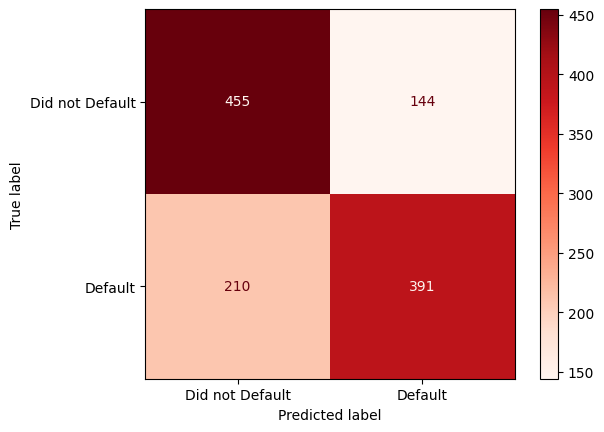

In [13]:
param_grid ={
    'max_depth':[3, 4, 5],
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators':[50, 100, 200, 300, 500],
    'max_features':['sqrt', 'log2', None]

}
rf_random = RandomizedSearchCV(
    estimator = clf_rf,
    param_distributions = param_grid,
    n_iter = 27,
    cv = 3,
    random_state = 0,
    verbose = 1,
    n_jobs = -1
)
# Fit the random search model
rf_random.fit(X_train, y_train)
# Output the best hyperparameters found
best_params = rf_random.best_params_
print(f"Best parameters found: {best_params}")
print(f"Best estimator is: {rf_random.best_estimator_}")
# Refit the model using the best hyperparameters
best_clf_rf = rf_random.best_estimator_
# To check all parameters currently in use
#print(f"Parameters currently in use: {best_clf_rf.get_params()}")
# Train the refitted model
best_clf_rf.fit(X_train, y_train)
# Calculate overall accuracy
y_pred = best_clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
# Calculate the percentage of correctly predicted instances for each class
cm = confusion_matrix(y_test, y_pred)
for i, class_name in enumerate(class_names):
  correct_predictions = cm[i, i]
  total_predictions = cm[i, :].sum()
  class_accuracy = correct_predictions / total_predictions * 100
  print(f"Percentage of correctly predicted {class_name}:{class_accuracy:.2f}%")
# Plot the confusion matrix
class_names = ['Did not Default', 'Default']
disp = ConfusionMatrixDisplay.from_estimator(
    best_clf_rf,
    X_test,
    y_test,
    display_labels = class_names,
    cmap = plt.cm.Reds
)
plt.show()

**CONCLUSIONS**

The current model for predicting car loan defaults shows moderate performance with an accuracy of 70.50%. It correctly identifies 75.96% of the cases where there was no default, but has significant limitations when predicting defaults, with a recall of only 65.06% for the “Default” class. This generates a risk for the financial institution due to false negatives (210 cases), which could go undetected.
